In [1]:
# standard lib imports
import os.path
import zipfile
import json
from functools import wraps

# 3rd party imports
import pandas as pd
from scipy.stats import entropy 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from matplotlib import pyplot as plt
from numpy import nan
%matplotlib inline

# project imports
from plotter import ReportPlotter
from functions import get_survey_year, get_fraction_of_answers, get_fraction_of_answers2
import log_config
logger = log_config.get_configured_logger('stdout')

# constants
IMG_PTH = os.path.join(os.getcwd(), './data/output')
plotter = ReportPlotter(IMG_PTH)

pd.set_option('display.max_rows', 85)
pd.set_option('display.max_columns', 85)

/home/kornel/Dokumente/Programmieren/udacity_ds/proj1/venv/lib/python3.8/site-packages/pandas/compat/__init__.py:117: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


# Section 1: Scope of the project

In this project, I was interestested in using Stack Overflow data from 2017 to better understand what makes people happy in their job. Precicely I wanted to answer the following questions:

1. How happy are people in average with their job?
2. Is there a connection between Satisfaction in the Job and loyalty towards the job and employer?
3. On what factors satisfied developers choose their job (not considering salary)? Do they look for different factors?
4. What are the most important factors contributing into Job-Satisfaction solely considering the data?

# Section 2: Data Understanding

In [2]:
# read survey data of 2019 and display overview of data
data_19 = get_survey_year(2019)
logger.info('Data has %i datapoints and %i parameters' % data_19.shape)
data_19.head()

2020-07-19 17:55:14 - stdout - INFO - Data has 88883 datapoints and 85 parameters


,Respondent,MainBranch,Hobbyist,OpenSourcer,OpenSource,Employment,Country,Student,EdLevel,UndergradMajor,EduOther,OrgSize,DevType,YearsCode,Age1stCode,YearsCodePro,CareerSat,JobSat,MgrIdiot,MgrMoney,MgrWant,JobSeek,LastHireDate,LastInt,FizzBuzz,JobFactors,ResumeUpdate,CurrencySymbol,CurrencyDesc,CompTotal,CompFreq,ConvertedComp,WorkWeekHrs,WorkPlan,WorkChallenge,WorkRemote,WorkLoc,ImpSyn,CodeRev,CodeRevHrs,UnitTests,PurchaseHow,PurchaseWhat,LanguageWorkedWith,LanguageDesireNextYear,DatabaseWorkedWith,DatabaseDesireNextYear,PlatformWorkedWith,PlatformDesireNextYear,WebFrameWorkedWith,WebFrameDesireNextYear,MiscTechWorkedWith,MiscTechDesireNextYear,DevEnviron,OpSys,Containers,BlockchainOrg,BlockchainIs,BetterLife,ITperson,OffOn,SocialMedia,Extraversion,ScreenName,SOVisit1st,SOVisitFreq,SOVisitTo,SOFindAnswer,SOTimeSaved,SOHowMuchTime,SOAccount,SOPartFreq,SOJobs,EntTeams,SOComm,WelcomeChange,SONewContent,Age,Gender,Trans,Sexuality,Ethnicity,Dependents,SurveyLength,SurveyEase
0,1,I am a student who is learning to code,Yes,Never,The quality of OSS and closed source software ...,"Not employed, and not looking for work",United Kingdom,No,Primary/elementary school,NaN,"Taught yourself a new language, framework, or ...",NaN,NaN,4,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,HTML/CSS;Java;JavaScript;Python,C;C++;C#;Go;HTML/CSS;Java;JavaScript;Python;SQL,SQLite,MySQL,MacOS;Windows,Android;Arduino;Windows,Django;Flask,Flask;jQuery,Node.js,Node.js,IntelliJ;Notepad++;PyCharm,Windows,I do not use containers,NaN,NaN,Yes,"Fortunately, someone else has that title",Yes,Twitter,Online,Username,2017,A few times per month or weekly,Find answers to specific questions;Learn how t...,3-5 times per week,Stack Overflow was much faster,31-60 minutes,No,NaN,"No, I didn't know that Stack Overflow had a jo...","No, and I don't know what those are",Neutral,Just as welcome now as I felt last year,Tech articles written by other developers;Indu...,14.0,Man,No,Straight / Heterosexual,NaN,No,Appropriate in length,Neither easy nor difficult
1,2,I am a student who is learning to code,No,Less than once per year,The quality of OSS and closed source software ...,"Not employed, but looking for work",Bosnia and Herzegovina,"Yes, full-time","Secondary school (e.g. American high school, G...",NaN,Taken an online course in programming or softw...,NaN,"Developer, desktop or enterprise applications;...",NaN,17,NaN,NaN,NaN,NaN,NaN,NaN,I am actively looking for a job,I've never had a job,NaN,NaN,Financial performance or funding status of the...,"Something else changed (education, award, medi...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,C++;HTML/CSS;Python,C++;HTML/CSS;JavaScript;SQL,NaN,MySQL,Windows,Windows,Django,Django,NaN,NaN,Atom;PyCharm,Windows,I do not use containers,NaN,Useful across many domains and could change ma...,Yes,Yes,Yes,Instagram,Online,Username,2017,Daily or almost daily,Find answers to specific questions;Learn how t...,3-5 times per week,Stack Overflow was much faster,11-30 minutes,Yes,A few times per month or weekly,"No, I knew that Stack Overflow had a job board...","No, and I don't know what those are","Yes, somewhat",Just as welcome now as I felt last year,Tech articles written by other developers;Indu...,19.0,Man,No,Straight / Heterosexual,NaN,No,Appropriate in length,Neither easy nor difficult
2,3,"I am not primarily a developer, but I write co...",Yes,Never,The quality of OSS and closed source software ...,Employed full-time,Thailand,No,"Bachelorâs degree (BA, BS, B.Eng., etc.)",Web development or web design,"Taught yourself a new language, framework, or ...",100 to 499 employees,"Designer;Developer, back-end;Developer, front-...",3,22,1,Slightly satisfied,Slightly satisfied,Not at all confident,Not sure,Not sure,"Iâm not actively looking, but I am open to n...",1-2 years ago,Interview with people in peer roles,No,"Languages, frameworks, and other techno

Many columns seem to contain more then one answer separated by semicolon. E.g. 'SONewContent'. These parameters needs special handling in Data Preparation. Furthermore we have two columns containing duplicate information about the currency: 'CurrencyDesc' and 'CurrencySymbol'.

In [3]:
# get all NOT numerical data
not_numeric_data = data_19.select_dtypes(exclude=['int16', 'int32', 'int64', 'float16', 'float32', 'float64'])
# chekc if the parameters contain semicolon (multiple answers)
mask = not_numeric_data.apply(lambda x: x.str.contains(';').any())
multiple_answers_data = not_numeric_data[mask.index[mask]]
del(mask)
logger.info('number of not numerical data: %i; number of parameters with multiple answers: %i' % 
            (not_numeric_data.shape[1], multiple_answers_data.shape[1]))
multiple_answers_data.head()

2020-07-19 17:55:17 - stdout - INFO - number of not numerical data: 79; number of parameters with multiple answers: 23


,EduOther,DevType,LastInt,JobFactors,WorkPlan,WorkChallenge,LanguageWorkedWith,LanguageDesireNextYear,DatabaseWorkedWith,DatabaseDesireNextYear,PlatformWorkedWith,PlatformDesireNextYear,WebFrameWorkedWith,WebFrameDesireNextYear,MiscTechWorkedWith,MiscTechDesireNextYear,DevEnviron,Containers,SOVisitTo,SONewContent,Gender,Sexuality,Ethnicity
0,"Taught yourself a new language, framework, or ...",NaN,NaN,NaN,NaN,NaN,HTML/CSS;Java;JavaScript;Python,C;C++;C#;Go;HTML/CSS;Java;JavaScript;Python;SQL,SQLite,MySQL,MacOS;Windows,Android;Arduino;Windows,Django;Flask,Flask;jQuery,Node.js,Node.js,IntelliJ;Notepad++;PyCharm,I do not use containers,Find answers to specific questions;Learn how t...,Tech articles written by other developers;Indu...,Man,Straight / Heterosexual,NaN
1,Taken an online course in programming or softw...,"Developer, desktop or enterprise applications;...",NaN,Financial performance or funding status of the...,NaN,NaN,C++;HTML/CSS;Python,C++;HTML/CSS;JavaScript;SQL,NaN,MySQL,Windows,Windows,Django,Django,NaN,NaN,Atom;PyCharm,I do not use containers,Find answers to specific questions;Learn how t...,Tech articles written by other developers;Indu...,Man,Straight / Heterosexual,NaN
2,"Taught yourself a new language, framework, or ...","Designer;Developer, back-end;Developer, front-...",Interview with people in peer roles,"Languages, frameworks, and other technologies ...",There's no schedule or spec; I work on what se...,Distracting work environment;Inadequate access...,HTML/CSS,Elixir;HTML/CSS,PostgreSQL,PostgreSQL,NaN,NaN,NaN,Other(s):,NaN,NaN,Vim;Visual Studio Code,I do not use containers,Find answers to specific questions;Learn how t...,Tech meetups or events in your area;Courses on...,Man,Straight / Heterosexual,NaN
3,Taken an online course in programming or softw...,"Developer, full-stack","Write code by hand (e.g., on a whiteboard);Int...","Languages, frameworks, and other technologies ...",There's no schedule or spec; I work on what se...,NaN,C;C++;C#;Python;SQL,C;C#;JavaScript;SQL,MySQL;SQLite,MySQL;SQLite,Linux;Windows,Linux;Windows,NaN,NaN,.NET,.NET,Eclipse;Vim;Visual Studio;Visual Studio Code,I do not use containers,Find answers to specific questions;Pass the ti...,Tech articles written by other developers;Indu...,Man,Straight / Heterosexual,White or of European descent
4,Taken an online course in programming or softw...,"Academic researcher;Developer, desktop or ente...","Write any code;Write code by hand (e.g., on a ...","Industry that I'd be working in;Languages, fra...",There is a schedule and/or spec (made by me or...,Being tasked with non-development work;Inadequ...,C++;HTML/CSS;Java;JavaScript;Python;SQL;VBA,HTML/CSS;Java;JavaScript;SQL;WebAssembly,Couchbase;MongoDB;MySQL;Oracle;PostgreSQL;SQLite,Couchbase;Firebase;MongoDB;MySQL;Oracle;Postgr...,Android;Linux;MacOS;Slack;Windows,Android;Docker;Kubernetes;Linux;Slack,Django;Express;Flask;jQuery;React.js;Spring,Flask;jQuery;React.js;Spring,Cordova;Node.js,Apache Spark;Hadoop;Node.js;React Native,IntelliJ;Notepad++;Vim,"Outside of work, for personal projects",Find answers to specific questions,Tech meetups or events in your area;Courses on...,Man,Straight / Heterosexual,White or of European descent;Multiracial


6 of the 86 parameters contain numerical data. 23 of the 79 non-numerical parameters contain sveral answers. These parameters needs to be splitted in several parameters for further analysis.
Let's get an overview of completeness of the data. 

In [4]:
# See how many values are missing:
(data_19.isna().sum()*100 / data_19.shape[0]).round(1).sort_values(ascending=False)

BlockchainOrg             45.8
CodeRevHrs                44.0
ConvertedComp             37.2
CompTotal                 37.1
MiscTechWorkedWith        33.0
BlockchainIs              32.3
PurchaseHow               31.2
MgrMoney                  31.2
MgrIdiot                  31.2
MgrWant                   31.1
PurchaseWhat              30.2
UnitTests                 29.5
WebFrameDesireNextYear    29.2
CompFreq                  28.8
WorkWeekHrs               27.4
MiscTechDesireNextYear    27.4
WebFrameWorkedWith        26.8
LastInt                   24.4
WorkChallenge             23.3
SOHowMuchTime             23.1
WorkPlan                  22.5
DatabaseDesireNextYear    22.2
SONewContent              21.7
WorkLoc                   21.2
WorkRemote                20.9
CodeRev                   20.8
JobSat                    20.1
CurrencyDesc              19.7
CurrencySymbol            19.7
FizzBuzz                  19.7
OrgSize                   19.2
ImpSyn                    19.2
CareerSa

The most important parameter for this analyis 'JobSat' has 20.1% missing data. These datapoints need to be dropped.
As a very basic consistency check it will be checked that everyone who specified a JobSatisfaction actually currently has a job. Therefor the 'Employment' and 'LastHireData' will be cross-checked.

In [5]:
# display all values for Employment and LastHireDate
print('Employment:\n' + ';\n'.join(map(str, set(data_19.Employment.values))))
print('\nLastHireDate:\n' + ';\n'.join(map(str, set(data_19.LastHireDate.values))))

Employment:
nan;
Independent contractor, freelancer, or self-employed;
Retired;
Employed full-time;
Employed part-time;
Not employed, but looking for work;
Not employed, and not looking for work

LastHireDate:
nan;
I've never had a job;
3-4 years ago;
1-2 years ago;
NA - I am an independent contractor or self employed;
Less than a year ago;
More than 4 years ago


For Employment we have to filter all out which are 'Retired', 'Not employed, but looking...' and 'Not employed, and...'
For LastHireData we have to filter for people never had a job. For  the data preparation we have to consider also that for some questions e.g. question2 where we are interested only about empolyed people we will also have to filter self-employed persons.

In [6]:
# define a filter-func for data-preparation section
def filter_selfemployed(df):
    "functions filters out all datapoints of self-employed survey participants"
    return df[~(
        (df.Employment == "Independent contractor, freelancer, or self-employed") | (
            df.LastHireDate == "NA - I am an independent contractor or self employed")
    )]

In [7]:
# get all datapoints with job-satisfaction
jobsat_data = data_19.dropna(subset=['JobSat'])
# look for Employment (retired and not employed) OR LastHireDate (never had a job)
err_mask1 = jobsat_data.Employment.isin([
    "Not employed, but looking for work",
    "Retired",
    "Not employed, and not looking for work",
]) | jobsat_data.LastHireDate.isin([
    "I've never had a job",
])
err_mask1.sum()

242

In [8]:
# look for LastHireData (NA - self employed) AND NOT Employment self-employed or NaN
err_mask2 = ~jobsat_data.Employment.isin([
    "Independent contractor, freelancer, or self-employed",
    nan
]) & jobsat_data.LastHireDate.isin([
    "NA - I am an independent contractor or self employed",
])
logger.info('%i errors found.' % err_mask2.sum())
jobsat_data[err_mask2].loc[:, ['Employment', 'LastHireDate']]

2020-07-19 17:55:18 - stdout - INFO - 422 errors found.


,Employment,LastHireDate
56,Employed full-time,NA - I am an independent contractor or self em...
65,Employed full-time,NA - I am an independent contractor or self em...
219,Employed full-time,NA - I am an independent contractor or self em...
608,Employed part-time,NA - I am an independent contractor or self em...
716,Employed full-time,NA - I am an independent contractor or self em...
...,...,...
87081,Employed full-time,NA - I am an independent contractor or self em...
87472,Employed full-time,NA - I am an independent contractor or self em...
88218,Employed full-time,NA - I am an independent contractor or self em...
88295,Employed full-time,NA - I am an independent contractor or self em...


In [9]:
err_mask_comb = err_mask1 | err_mask2
err_mask_comb.sum()

664

664 errorneous datapoints were identified which should be dropped.

# Section 3: Data Preparation

Apply findings from previous section and filter datapoints with no data in parameter of interest and datapoints with errors:

In [10]:
# drop all rows (datapoints) with no values in the variable of interest
data_19 = data_19.dropna(subset=['JobSat'])

# drop all rows (datapoints) with inconsitencies inentified in section2 to 
# make sure only people are considered which have actuually a job
data_19 = data_19[~err_mask_comb]

# drop duplicate parameter
data_19.drop('CurrencySymbol', axis=1, inplace=True)

transform parameters with multiple values in one cell to individual boolean parameters:

In [11]:
def multiple_answers_to_dummies(df, col, sep):
    """
    function transforms columns which have more then one answer separated by a character into separate columns.
    a DataFrame is returned where the col is replaced by dummies.
    
    Parameters:
    -----------
    df: pd.DataFrame
    col: str
        name of the column with more than onevalue per cell
    sep: str
        characters with which the values are separated
        
    Returns:
    --------
    pd.DataFrame
    """
    dummies = df[col].str.get_dummies(sep=sep)
    dummies.columns = ['%s_%s' % (col, val.title().replace(' ', '')) for val in dummies.columns]
    logger.info('Column %s transformed into %i dummi-columns' % (col, dummies.shape[1]))
    return pd.concat([df.drop(col, axis=1), dummies], axis=1)

for col in multiple_answers_data.columns:
    data_19 = multiple_answers_to_dummies(data_19, col, ';')

data_19.head()

2020-07-19 17:55:19 - stdout - INFO - Column EduOther transformed into 9 dummi-columns
2020-07-19 17:55:20 - stdout - INFO - Column DevType transformed into 24 dummi-columns
2020-07-19 17:55:21 - stdout - INFO - Column LastInt transformed into 6 dummi-columns
2020-07-19 17:55:22 - stdout - INFO - Column JobFactors transformed into 10 dummi-columns
2020-07-19 17:55:23 - stdout - INFO - Column WorkPlan transformed into 4 dummi-columns
2020-07-19 17:55:24 - stdout - INFO - Column WorkChallenge transformed into 9 dummi-columns
2020-07-19 17:55:26 - stdout - INFO - Column LanguageWorkedWith transformed into 28 dummi-columns
2020-07-19 17:55:29 - stdout - INFO - Column LanguageDesireNextYear transformed into 28 dummi-columns
2020-07-19 17:55:31 - stdout - INFO - Column DatabaseWorkedWith transformed into 14 dummi-columns
2020-07-19 17:55:32 - stdout - INFO - Column DatabaseDesireNextYear transformed into 14 dummi-columns
2020-07-19 17:55:34 - stdout - INFO - Column PlatformWorkedWith transfo

,Respondent,MainBranch,Hobbyist,OpenSourcer,OpenSource,Employment,Country,Student,EdLevel,UndergradMajor,OrgSize,YearsCode,Age1stCode,YearsCodePro,CareerSat,JobSat,MgrIdiot,MgrMoney,MgrWant,JobSeek,LastHireDate,FizzBuzz,ResumeUpdate,CurrencyDesc,CompTotal,CompFreq,ConvertedComp,WorkWeekHrs,WorkRemote,WorkLoc,ImpSyn,CodeRev,CodeRevHrs,UnitTests,PurchaseHow,PurchaseWhat,OpSys,BlockchainOrg,BlockchainIs,BetterLife,ITperson,OffOn,...,DevEnviron_Notepad++,DevEnviron_Phpstorm,DevEnviron_Pycharm,DevEnviron_Rstudio,DevEnviron_Rubymine,DevEnviron_SublimeText,DevEnviron_Textmate,DevEnviron_Vim,DevEnviron_VisualStudio,DevEnviron_VisualStudioCode,DevEnviron_Xcode,DevEnviron_Zend,Containers_Development,Containers_IDoNotUseContainers,"Containers_OutsideOfWork,ForPersonalProjects",Containers_Production,Containers_Testing,SOVisitTo_ContributeToALibraryOfInformation,SOVisitTo_FindAnswersToSpecificQuestions,SOVisitTo_GetASenseOfBelongingToTheDeveloperCommunity,SOVisitTo_LearnHowToDoThingsIDidnâTNecessarilyLookFor,SOVisitTo_MeetOtherPeopleWithSimilarSkillsOrInterests,SOVisitTo_PassTheTime/Relax,SONewContent_CoursesOnTechnologiesYou'ReInterestedIn,SONewContent_IndustryNewsAboutTechnologiesYou'ReInterestedIn,SONewContent_TechArticlesWrittenByOtherDevelopers,SONewContent_TechMeetupsOrEventsInYourArea,Gender_Man,"Gender_Non-Binary,Genderqueer,OrGenderNon-Conforming",Gender_Woman,Sexuality_Bisexual,Sexuality_GayOrLesbian,Sexuality_Straight/Heterosexual,Ethnicity_Biracial,Ethnicity_BlackOrOfAfricanDescent,Ethnicity_EastAsian,Ethnicity_HispanicOrLatino/Latina,Ethnicity_MiddleEastern,Ethnicity_Multiracial,"Ethnicity_NativeAmerican,PacificIslander,OrIndigenousAustralian",Ethnicity_SouthAsian,Ethnicity_WhiteOrOfEuropeanDescent
2,3,"I am not primarily a developer, but I write co...",Yes,Never,The quality of OSS and closed source software ...,Employed full-time,Thailand,No,"Bachelorâs degree (BA, BS, B.Eng., etc.)",Web development or web design,100 to 499 employees,3,22,1,Slightly satisfied,Slightly satisfied,Not at all confident,Not sure,Not sure,"Iâm not actively looking, but I am open to n...",1-2 years ago,No,I was preparing for a job search,Thai baht,23000.0,Monthly,8820.0,40.0,Less than once per month / Never,Home,Average,No,NaN,"No, but I think we should",Not sure,I have little or no influence,Linux-based,NaN,NaN,Yes,Yes,Yes,...,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,1,0,1,0,0,1,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0
3,4,I am a developer by profession,No,Never,The quality of OSS and closed source software ...,Employed full-time,United States,No,"Bachelorâs degree (BA, BS, B.Eng., etc.)","Computer science, computer engineering, or sof...",100 to 499 employees,3,16,Less than 1 year,Very satisfied,Slightly satisfied,Very confident,No,Not sure,I am not interested in new job opportunities,Less than a year ago,No,I was preparing for a job search,United States dollar,61000.0,Yearly,61000.0,80.0,Less than once per month / Never,Home,A little below average,No,NaN,"No, but I think we should",Developers typically have the most influence o...,I have little or no influence,Windows,Not at all,"Useful for decentralized currency (i.e., Bitcoin)",Yes,SIGH,Yes,...,0,0,0,0,0,0,0,1,1,1,0,0,0,1,0,0,0,0,1,0,0,0,1,1,1,1,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1
4,5,I am a developer by profession,Yes,Once a month or more often,"OSS is, on average, of HIGHER quality than pro...",Employed full-time,Ukraine,No,"Bachelorâs degree (BA, BS, B.Eng., etc.)","Computer science, computer engineering, or sof...","10,000 or more employees",16,14,9,Very dissatisfied,Slightly dissatisfied,Somewhat confident,Yes,No,I am not interested in new job opportunities,Less than a year ago,No,I was preparing for a job search,Ukrainian hryvnia,NaN,NaN,NaN,55.0,A few days each month,Office,A little above average,"Yes, because I see value in code review",NaN,"Yes, it's part of our process",Not sure,I have little or no influence,Linux-based,Not at all,NaN,Yes,Also Yes,Yes,...,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0

For comparisons and training a regression model we need to transform the ordinal data of the dependent variable to integers:

In [12]:
# change nominal values to intergers in order to represent ordinal scale
data_19['JobSat'].replace({
    'Very dissatisfied': 1,
    'Slightly dissatisfied': 2,
    'Neither satisfied nor dissatisfied': 3,
    'Slightly satisfied': 4,
    'Very satisfied': 5
}, inplace=True)

For some of the questions - in particular questions 2 and 3 - we are only interested in the JobSatisfaction of employed people. Therefor we have to prepare two datasets: One with all participants and one where we filtered out self-employed persons.

In [13]:
data_19_all = data_19
data_19_employed = filter_selfemployed(data_19)

del(data_19)

In the following I programmed functions used for the preparation of the data befor using it for training if a machine learning model:
* data-points with no data at the parameter of interest are dropped
* drops parameters which missing values exceed a certain fraction of the whole dataset (50% missing data were used in this project)
* fills missing data with the mean for numerical and boolean parameters
* transform categorical parametrs to dummy-numerical parameters which can be used for training a numerical model. Categories with very little representation in the data will be dropped to avoid too large datasets and overfitting.
* a wrapper function using all the abouve mentioned functions before calling a function fitting a predictive model

In [14]:
def clean_data(df, response_col, **kwargs):
    """
    function drops all datapoints which have missing values in the parameter of interest
    and all columns which then have only missing datas left.
    
    Parameters:
    -----------
    df: pandas.DataFrame
    response_col: str
        name of the column with the parameter of interest
    kwargs:
        additional key-word arguments
        
    Returns:
    --------
    pd.DataFrame
    """
    #Dropping rows where the response-col has missing values
    df  = df.dropna(subset=[response_col], axis=0)

    #Drop columns with all NaN values
    return df.dropna(how='all', axis=1)

       
def handle_missing_data(df, drop=True, drop_na_fraction=0.5, **kwargs):
    """
    function handles parameters with missing values: 
    All columns with more missing data then the specified fraction gets droped
    The remaining columns the NAs are replaced by the mean of the parameter
    
    Parameters:
    -----------
    df: pandas.DataFrame
    drop: bool, True
        whether to drop columns with a certain amount of missing data
    drop_na_fraction: float
        fraction of na-values which must be exceeded in order to drop the column
    kwargs:
        for catching additional keyword arguments 
    """
    import math
    # drop columns
    if drop:
        df = df.dropna(thresh=math.ceil(df.shape[0]*drop_na_fraction), axis=1)
    else:
        #Drop columns with all NaN values
        df = df.dropna(how='all', axis=1)
    
    # fill na with mean (for numerical or boolean data)
    quant_cols = df.columns[(df.dtypes == 'int64') | (df.dtypes == 'float64') | (df.dtypes == 'bool')]
    mean = df[quant_cols].mean()
    df[quant_cols] = df[quant_cols].fillna(value=mean)
    return df


def handle_categorical_data(df, drop_fraction=0.1, **kwargs):
    """
    function replaces categroical parameters with several boolean dummy-parameters. 
    In order to avoid too many parameters a drop-fraction can be specified. All dummy-columns having less
    observations then the specified fraction will be removed.
    
    Parameters:
    -----------
    df: pandas.DataFrame
    drop_fraction: float, 0.1
        fraction of values which must not be 0 if not dropped
    kwargs:
        additional keyword arguments
    """
    logger.debug(df.shape)
    
    def drop_cat(df):
        """
        function drops inplace all columns (must only contain dummy-columns) 
        with less entries then the drop-fraction from enclosing scope
        """
        mask = df.apply(lambda x: x.sum() / df.shape[0]) < drop_fraction
        return df.columns[mask]
      
    # identify existing categorical columns with less values then the drop-fraction
    existing_dummys = df.columns[df.isin([0, 1]).all()]
    drop_cols = list(drop_cat(df.loc[:, existing_dummys]))
    
    # Pull a list of the column names of the categorical variables
    cat_cols = list(df.select_dtypes(include=['object']).columns)

    # create dummy all the cat_cols
    # Memroy Errors were encountered due to too big data-frames -> column wise dummy generation implemented 
    # with catching memory errors.
    try:
        col = cat_cols[0]
        cat_df = pd.get_dummies(df[col], prefix=col, prefix_sep='_', drop_first=True, dummy_na=True)
        for col in cat_cols[1:]:
            cat_df = pd.concat(
                [cat_df, pd.get_dummies(df[col], prefix=col, prefix_sep='_', drop_first=True, dummy_na=True)],
                axis=1
            )            
            # drop all columns with less values then the specified fraction
            cat_df.drop(drop_cat(cat_df), axis=1, inplace=True)
            
    except MemoryError:
        # further categroical columns will be not considered - for loop exited
        logger.warning(
            'Memory-Error catched - drop fraction %.2f too low. '
            'Dummy-generation of categorical data stopped.' % drop_fraction)
        
    logger.debug('exiting function "handle categorical data"')
    logger.debug('shape of categorical data: %s; shape of df %s' % (cat_df.shape, df.shape))
    
    # insert new cat-cols to original df with non categoriacal data and drop part of existing dummy-cols
    return pd.concat([df.drop(drop_cols + cat_cols, axis=1), cat_df], axis=1)

    
def optimized_data(func):
    """
    decorator function for finding optimal data for the training of a predictive model
    
    Parameters:
    ----------
    func: function
        function to be decorated

    Returns:
    --------
    function
    """
    from numpy import arange
    
    @wraps(func)
    def with_optimal_data(df, response_col, start=0.4, end=0, increment=-0.05, **kwargs):
        logger.info('handling missing data.')
        df_cleaned = handle_missing_data(clean_data(df, response_col, **kwargs), **kwargs)
        
        # use different cutoffs for categorical data (how many percent may not be 0) and find optimized
        # dataset for training the model without overfitting
        test_score_prev = 0
        results_prev = None
        for dropf in arange(start, end, increment):
            logger.info('starting optimization of model with drop_fraction: %.2f' % dropf)
            
            # pass the drop-fraction to 'handle_categorical_data' and pass the output (dataframe) to the
            # training function of the model
            results = func(handle_categorical_data(df_cleaned, drop_fraction=dropf), response_col, **kwargs)
            
            logger.info('testdata shows score of %.2f - trainingdata a score of %.2f '
                        '(%i parameters used)' % (results[0], results[1], results[3].shape[1]))
            # check for overfitting (decreasing testscore)
            if results[0] < test_score_prev:
                logger.info('usage of more categorical data lead to an overfitting')
                return results_prev
            # else
            test_score_prev = results[0]
            results_prev = results
        return results
    return with_optimal_data

# Section 4: Data Modelling

In [15]:
# funcs for prepareing data

def fit_lin_reg(df, response_col, test_size=None, rand_state=None, normalize=True, **kwargs):
    """
    Function fits a linear regression model to a set of data
    
    Parameters:
    -----------
    df: pandas.Dataframe
        prepared data for fitting and testing the model
    response_col: str
        name of the column/parameter which should be predicted
    test_size: float, None
        fraction of dataset which should be used for testing the model if None is 
        passed, default from sklearn is used (0.25)
    rand_state: int, None
        random seed, if int is passed reproduceable output can be performed
    normalize: bool, True
        whether to normalize estimation parameters     
    kwargs: dictionary
        additional kwargs passed to sklearn.model_selection.train_test_split function
        important kwargs might be test_size or random_state
        
    Returns:
    --------
    test_score: float
        indicator for performance of linear model
    train_score: float
        indicator how well the model fits the training data
    lm_model: sklearn.linearmodel
        fitted model
    X: pandas.DataFrame
        data of parameters for prediction
    X_test: pandas.DataFrame
        datapoints of used parameters used for testing the model
    X_train: pandas.DataFrame
        datapoints of used parameters used for training the model
    y: pandas.Series
        predicted variable of all datapoints
    y_test: pandas.Series
        predicted variable of datapoints used for testing the model
    y_train: pandas.Series
        predicted variable of datapoints used for training the model
    """
    
    #Split into explanatory and response variables
    X = df.drop(response_col, axis=1)
    y = df[response_col]
    
    #Split into train and test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=rand_state)

    lm_model = LinearRegression(normalize=normalize) # Instantiate
    lm_model.fit(X_train, y_train) #Fit

    #Predict using your model
    y_test_preds = lm_model.predict(X_test)
    y_train_preds = lm_model.predict(X_train)

    #Score using your model
    test_score = r2_score(y_test, y_test_preds)
    train_score = r2_score(y_train, y_train_preds)

    return test_score, train_score, lm_model, X, X_test, X_train, y, y_test, y_train

In [16]:
# train model for all participants
# JobSeek is droped because this is a obvious case of reversed causality. 
# A low JobSat will cause people to look for a job, not the other way round.
results_all = optimized_data(fit_lin_reg)(
    data_19_all.drop(['JobSeek'], axis=1), 
    'JobSat', start=0.20, end=0.01, increment=-0.025, rand_state=42
)
test_score_all, train_score_all, lm_model_all, X_all, X_test_all, X_train_all, y_all, y_test_all, y_train_all = results_all

2020-07-19 17:55:52 - stdout - INFO - handling missing data.
2020-07-19 17:55:53 - stdout - INFO - starting optimization of model with drop_fraction: 0.20
2020-07-19 17:55:58 - stdout - INFO - testdata shows score of 0.45 - trainingdata a score of 0.45 (173 parameters used)
2020-07-19 17:55:58 - stdout - INFO - starting optimization of model with drop_fraction: 0.18
2020-07-19 17:56:03 - stdout - INFO - testdata shows score of 0.46 - trainingdata a score of 0.46 (201 parameters used)
2020-07-19 17:56:03 - stdout - INFO - starting optimization of model with drop_fraction: 0.15
2020-07-19 17:56:07 - stdout - INFO - testdata shows score of 0.46 - trainingdata a score of 0.46 (222 parameters used)
2020-07-19 17:56:07 - stdout - INFO - starting optimization of model with drop_fraction: 0.13
2020-07-19 17:56:12 - stdout - INFO - testdata shows score of 0.47 - trainingdata a score of 0.46 (251 parameters used)
2020-07-19 17:56:12 - stdout - INFO - starting optimization of model with drop_frac

In [17]:
# train model only for employees
results_emp = optimized_data(fit_lin_reg)(
    data_19_employed.drop(['JobSeek'], axis=1), 
    'JobSat', start=0.20, end=0.01, increment=-0.025, rand_state=42
)
test_score_emp, train_score_emp, lm_model_emp, X_emp, X_test_emp, X_train_emp, y_emp, y_test_emp, y_train_emp = results_emp

2020-07-19 17:56:23 - stdout - INFO - handling missing data.
2020-07-19 17:56:24 - stdout - INFO - starting optimization of model with drop_fraction: 0.20
2020-07-19 17:56:28 - stdout - INFO - testdata shows score of 0.45 - trainingdata a score of 0.46 (175 parameters used)
2020-07-19 17:56:28 - stdout - INFO - starting optimization of model with drop_fraction: 0.18
2020-07-19 17:56:32 - stdout - INFO - testdata shows score of 0.46 - trainingdata a score of 0.46 (200 parameters used)
2020-07-19 17:56:32 - stdout - INFO - starting optimization of model with drop_fraction: 0.15
2020-07-19 17:56:38 - stdout - INFO - testdata shows score of 0.46 - trainingdata a score of 0.46 (219 parameters used)
2020-07-19 17:56:38 - stdout - INFO - usage of more categorical data lead to an overfitting


# Section 5: Evaluate Results

# Evaluate the Results

## Question1: How happy are people with their job?

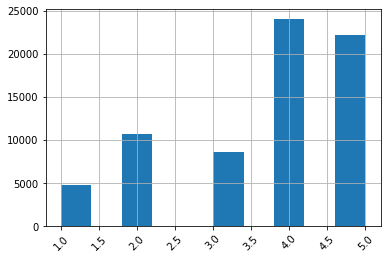

In [18]:
# create histogram
data_19_all['JobSat'].hist(xrot=45)

In [19]:
# some descriptive statistics about job-happiness (careful with the interpretation though as this is a ordinal parameter)
data_19_all['JobSat'].describe()

count    70324.000000
mean         3.684574
std          1.249053
min          1.000000
25%          3.000000
50%          4.000000
75%          5.000000
max          5.000000
Name: JobSat, dtype: float64

In [20]:
# fraction of people dissatisfied with their current job situation
sum(data_19_all['JobSat'].isin([1, 2])) / float(data_19_all.shape[0])

0.22013821739377737

### Conclusion of question1:
The data shows that great majority of people is happy in their current job situation (slightly satisfied or very satisfied). Only 22% state that they are unsatisfied with their job-situation.

## Question2: Is there a connection between Satisfaction in the Job and loyalty towards their job?

In [21]:
# For answering this question me must filter also all self-employed and freelancers
# # # # # data_19_ = data_19[data_19.Employment.isin(['Employed full-time', 'Employed part-time'])]
data_19_employed.groupby('JobSeek').apply(lambda x: x['JobSat'].describe()).sort_values('mean')

JobSat,count,mean,std,min,25%,50%,75%,max
JobSeek,,,,,,,,
I am actively looking for a job,6999.0,2.610516,1.264881,1.0,2.0,2.0,4.0,5.0
"Iâm not actively looking, but I am open to new opportunities",38334.0,3.565190,1.167037,1.0,3.0,4.0,4.0,5.0
I am not interested in new job opportunities,18165.0,4.338013,1.027496,1.0,4.0,5.0,5.0,5.0


This table shows a very strong connection between the job satisfaction and the willingness of people getting a new job.

In [22]:
data_19_employed.groupby('LastHireDate').apply(lambda x: x['JobSat'].describe()).sort_values('mean')

JobSat,count,mean,std,min,25%,50%,75%,max
LastHireDate,,,,,,,,
More than 4 years ago,13318.0,3.616909,1.264504,1.0,3.0,4.0,5.0,5.0
3-4 years ago,10369.0,3.624265,1.248384,1.0,3.0,4.0,5.0,5.0
1-2 years ago,18523.0,3.635318,1.244697,1.0,3.0,4.0,5.0,5.0
Less than a year ago,21041.0,3.790267,1.234590,1.0,3.0,4.0,5.0,5.0


The results are somewhat surprising: The Job-Satisfaction seems with a mean of 3.79 highest in the first year drop significantly towards the second (3.63) and the decrease very slightly with the time people stay at their job.

This seems to be at first glance contradicting to the first result, that unsatisfied employees look actively for a new job and therefor should not be sticking to their position when theyend up in a position or working environment with which they are not comfortable with. So let's have a look if there are differences between the answers compared to 

In [23]:
def reindex_timehired(df):
    """
    reindex aggregated DataFrame based on index-values representing 'LastHireDate'-column
    """
    return df.reindex(['Less than a year ago', '1-2 years ago', '3-4 years ago', 'More than 4 years ago'])

comp_df = pd.DataFrame({
    'satisfied': get_fraction_of_answers(
        data_19_employed[data_19_employed['JobSat'].isin([4, 5])], col='LastHireDate'),
    'dissatisfied': get_fraction_of_answers(
        data_19_employed[data_19_employed['JobSat'].isin([1, 2])], col='LastHireDate')
})
comp_df['diff'] = comp_df['satisfied'] - comp_df['dissatisfied']
comp_df = reindex_timehired(comp_df)
comp_df.style.bar(subset=['diff'], align='mid', color=['#d65f5f', '#5fba7d'])

/home/kornel/Dokumente/Programmieren/udacity_ds/proj1/functions.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(subset=[col], inplace=True)


,satisfied,dissatisfied,diff
Less than a year ago,0.348322,0.286100,0.062221
1-2 years ago,0.287439,0.304595,-0.017156
3-4 years ago,0.160153,0.175914,-0.015761
More than 4 years ago,0.204086,0.233390,-0.029304


This graph shows a rather surprising result: The fractions of satisfied vs dissatisfied employees are not evenly distributed. But while people which are dissatisfied with their job claim to look for other opportunities and therefor would not to be expected to be very long at their current position, it seems to be the other way round:
Employees who are dissatisfied are relatively longer in their current job compared to satisfied employees.

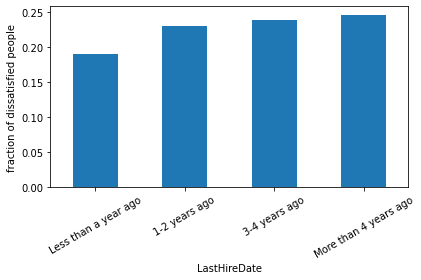

In [24]:
# calculate fraction of people with low job-satisfaction (1 or 2) grouped by time they are hired
fraction_dissatisfied = data_19_employed.groupby('LastHireDate').apply(
    lambda x: x['JobSat'].isin([1, 2]).sum() / x['JobSat'].count()
)
fraction_dissatisfied = reindex_timehired(fraction_dissatisfied)
ax = fraction_dissatisfied.plot.bar(rot=30)
ax.set_ylabel("fraction of dissatisfied people")

fig = ax.get_figure()
plt.tight_layout()
fig.savefig(os.path.join(IMG_PTH, 'satisfied_lasthired2.png'), format='png', dpi=300)

The second graph shows the fraction of dissatisfied people compared to all people within the same hireing-time. It shows that the dissatisfaction seems to increase the longer people stay at their job. While there is a big decrese in satisfaction from the first year to the second (people seem to be very motivated and idealistic at the beginning of their job) the decrease in the following years is lower but still there.
Maybe there are some changes in the comapny or people get bored so that they become dissatisfied. let's find out in the next questions.

### Conclusion of Question 2:
The analysis showed a clrea connection between job satisfaction and the loyalty of employees towards their employer. Unsatisfied persons are much more likely to look for a new job. It is however surprising that JobSatisfaction is lower for people which are long in their job. The two discoveries seemed to be contradicting at first glance; there might be some changes in the work-conditions over time which are causing these decreases.
People in their first year in the job are in average more satisfied then people longer in their job.

## 3. Question: On what factors satisfied developers choose their job (not considering salary)
Imagine that you are deciding between two job offers with the same compensation, benefits, and location. Of the following factors, which 3 are MOST important to you?

In [25]:
comp_df = pd.DataFrame({
    'all': get_fraction_of_answers2(
        data_19_employed, 'JobFactors'),
    'satisfied': get_fraction_of_answers2(
        data_19_employed[data_19_employed['JobSat'].isin([4, 5])], 'JobFactors'),
    'dissatisfied': get_fraction_of_answers2(
        data_19_employed[data_19_employed['JobSat'].isin([1, 2])], 'JobFactors')
})
comp_df['difference'] = comp_df['satisfied'] - comp_df['dissatisfied']
comp_df.sort_values('difference', ascending=False, inplace=True)
comp_df.style.bar(subset=['difference'], align='mid', color=['#d65f5f', '#5fba7d'])

,all,satisfied,dissatisfied,difference
OfficeEnvironmentOrCompanyCulture,0.497827,0.516792,0.462913,0.053879
SpecificDepartmentOrTeamI'DBeWorkingOn,0.125358,0.131225,0.116366,0.014859
FlexTimeOrAFlexibleSchedule,0.458203,0.457973,0.449865,0.008107
DiversityOfTheCompanyOrOrganization,0.066538,0.067909,0.063821,0.004088
HowWidelyUsedOrImpactfulMyWorkOutputWouldBe,0.230779,0.234081,0.231457,0.002625
"Languages,Frameworks,AndOtherTechnologiesI'DBeWorkingWith",0.541497,0.541621,0.542051,-0.000430
IndustryThatI'DBeWorkingIn,0.141941,0.142707,0.144022,-0.001315
FinancialPerformanceOrFundingStatusOfTheCompanyOrOrganization,0.139107,0.134120,0.141186,-0.007066
OpportunitiesForProfessionalDevelopment,0.436911,0.427857,0.456744,-0.028886
RemoteWorkOptions,0.300057,0.289911,0.325131,-0.035221


In [26]:
# create a plot for the report


plotter.set_label_rot(30)
# orig_width = plotter.config.width
plotter.config.width = 1200  #orig_width * 1.2
plotter.config.height = 720  # plotter.config.height * 1.2
plotter.config.truncate_label = -1
short_index = [
    'Company culture', 
    'Department/ team to work in', 
    'Flex time',
    'Diversity of company', 
    'Impact of work', 
    'technologies/ frameworks to work with',
    'Industry to work in', 
    'Financial performance of company', 
    'Remote work options', 
    'Development opportunities'
]
idx_copy = comp_df.copy()
comp_df.index = short_index
plotter.export_bar_plot(
    comp_df.drop('all', axis=1).sort_values('difference', ascending=False),
    title='Most important factors for choosing a job', 
    y_title='Fraction of people giving this answer'
)

### Conclusion of question3:
The plot shows that the differences between the two groups is not that significant. Satisfied and dissatisfied seem to have more or less the same priorities what they look for. The most important criterias (except salary and location) seems to be:

*The technologies and frameworks to work with
*Company culture
*Possibilities for flex time
*Possibilities for professional development

Satisfied people seem to tend to look a little more for the company culture (+5%) and less for professional development possibilities and remote work options (-3%).

## Question4: What are the most important factors contributing into Job-Satisfaction?

In [27]:
def coef_weights(coefficients, X_train):
    """
    Provides a dataframe that can be used to understand the most influential coefficients
    in a linear model by providing the coefficient estimates along with the name of the 
    variable attached to the coefficient    
    
    Parameters:
    -----------
    coefficients:
        the coefficients of the linear model
    X_train: pandas.Dataframe
        the training data, so the column names can be used
        
    Returns:
    --------
    coefs_df: pandas.DataFrame
        coefficient, estimate, and abs(estimate)
    """
    from numpy import abs
    
    coefs_df = pd.DataFrame()
    coefs_df['est_int'] = X_train.columns
    coefs_df['coefs'] = coefficients
    coefs_df['abs_coefs'] = abs(coefficients)
    coefs_df = coefs_df.sort_values('abs_coefs', ascending=False)
    return coefs_df

#Use the function
coef_df_emp = coef_weights(lm_model_emp.coef_, X_train_emp)

#A quick look at the top results
coef_df_emp.head(20)

,est_int,coefs,abs_coefs
136,CareerSat_Very satisfied,1.715153,1.715153
135,CareerSat_Slightly satisfied,1.079158,1.079158
138,MgrIdiot_Very confident,0.532612,0.532612
137,MgrIdiot_Somewhat confident,0.312446,0.312446
41,WorkChallenge_ToxicWorkEnvironment,-0.226897,0.226897
141,MgrWant_No,-0.201789,0.201789
36,WorkChallenge_LackOfSupportFromManagement,-0.199477,0.199477
161,"PurchaseHow_The CTO, CIO, or other management ...",-0.190776,0.190776
143,MgrWant_Yes,-0.184308,0.184308
142,MgrWant_Not sure,-0.160648,0.160648


### Conclusion of Question4:

The r2^shows a value of 0.47 for the training-data. That means that 47% of the variance in the job-satisfaction can be exlained by the parameters from the survey. So there are many factors relevant for how satisfied are within their job which are not covered in the survey or not used for the training of the model.

The results in the table abouve show the factors of the 20 most important parameters used in the fitting of the linear regression model sorted by their size. Before the training of the model, we normalized the parameters to be able to comapre them. A high number therefor shows a strong linear relationship between the parameter used for prediction and a high JobSatisfaction.

The most influencal parameters on the Job Satisfaction seems to be the Career-Satisfaction (if you are very or slightly satisfied) which is not very surprising.

It is very striking, however, that two answers to the question 'MgrIdiot' (How confident are you that your manager knows what they’re doing?) are within the 4 most important parameters for the prediction of the job satisfaction. People that specify their greatest work challange as a lack of support from manageement is the 7th position. Good and competent leadership seems key for a high job-satisfaction.
Another important factor seems to be the influence and the participation of the developers in decisions about the purchase of new technologies ('PurchaseHow' and 'PurchaseWhat'). Participants of the survey who states that the management decides purchases without the involvement of developers have a regressionfactor of -0.19 with jobsatisfaction.

Another factor which seems to have beneficial influence the work-satisfaction seems to be structured work-flow with a clear schedule or spec.

In [28]:
# generate plot for report

idx_new = [
    'Very satisfied with career',
    'Slightly satisfied with career',
    'Manger very much knows what he is doing',
    'Manger more or less knows what he is doing',
    'Greatest challange at work: Toxic work environment',
    'No whish to be a manager in future',
    'Greatest challange at work: Lack of support from management',
    'Developers not included in purchasing of new technology',
    'Whish to be a manager in future',
    'Unsure if want to be a manager in future',
    'Less then a year ago hired',
    'No personal influence on purchasing of new technology',
    'Structured work: There is a schedule or spec and my work alignes',
    'Last resumé update due to something else changed (education, award, media, etc.)',
    'Structured work: There is a schedule or spec and I follow it very closely', 
    'Would prefer to work in an Office',
    "We don't use unittests but should",
    'Used "Stack Overflow Jobs"',
    'Greatest challange at work: Non­work commitments',
    'Not sure how purchase decisions for new technologies are made',
]


'''   
    'Last resumé update due to changed job status',
    'Developers not included in purchasing of new technology',
    'Manger knows what he is doing - no answer',
    'Slightly dissatisfied with career',
    'Last resumé update due to Something else changed (education, award, media, etc.)',
    'Participitation frequency on Q&A on Stack Overflow: No answer',
    'Need to be Mgr to make more money, no answer',
    'Having a Stack Overflow Account',
    'Developers included in purchasing of new technology?: No answer',
    'No personal influence on purchasing of new technology',
    'Last hire date less then a year ago',
    'Ambitions to become a Mgr: No answer',
    'Would prefer to work in an Office',
    "We don't use unittests but should",
    'Used "Stack Overflow Jobs"',
    "I'm full time remote",
'''

plot_df = coef_df_emp.iloc[:20, [1]]
plot_df.index = idx_new

plotter.config.show_legend = False
plotter.set_label_rot(-30)
plotter.export_horizontal_bar_plot(plot_df[::-1], title='Most important factors for job satisfaction', x_title='coefficient of linear regression model', use_colmap=True)